In [1]:
import json

In [2]:
import numpy as np
import scipy.stats as scs
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [3]:
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelBinarizer, StandardScaler
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.metrics import (precision_recall_fscore_support,
                             roc_auc_score,
                             precision_recall_curve,
                             average_precision_score,
                             roc_curve)
from sklearn.externals import joblib
from sklearn.base import clone
from sklearn.neighbors import KNeighborsClassifier
np.random.seed(369)

In [4]:
from frag_tools import (DropColumns,
                        AddressLatLong,
                        CurrentMakeDummies,
                        Binarize,
                        ChangeTypes,
                        custom_zip_cleaning)
from various_tools import (roc,
                           plot_roc,
                           cross_val_metrics,
                           make_metric_df)

In [5]:
df = pd.read_csv('/mnt/c/Users/kurtrm/Downloads/Predictive_Maintenance_Transformer_Overload_PA.csv', sep=';')

In [6]:
pipe = make_pipeline(CurrentMakeDummies(['Manufacturer',
                                         'Repairs',
                                         'Overloads',
                                         'AssetType']),
                     ChangeTypes(['Age', 'AssetZip'],
                                 [lambda x: float(x.replace(',', '.')),
                                  custom_zip_cleaning]),
                     Binarize(['VegMgmt',
                               'PMLate',
                               'WaterExposure',
                               'MultipleConnects',
                               'Storm']),
                     AddressLatLong(),
                     DropColumns(['AssetCity',
                                  'AssetId',
                                  'AvgRepairCost',
                                  'AssetState',
                                  'MilesFromOcean',
                                  'AssetLocation',
                                  'locationID',
                                  'Latitude1',
                                  'Longitude1',
                                  'Latitude',
                                  'Longitude',
                                  'Overloads_Below 100%',
                                  'Overloads_100-120%',
                                  'Overloads_120-150%',
                                  'Overloads_Above 150%',
                                  'AssetZip']))
transformed = pipe.fit_transform(df)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(transformed.drop('Status', axis=1).values, transformed['Status'].values, test_size=.2)

In [8]:
_, gbc_final = joblib.load('refined_models.pkl')

In [9]:
gbc_final.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.005, loss='deviance', max_depth=5,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=1000,
              presort='auto', random_state=None, subsample=0.5, verbose=0,
              warm_start=False)

In [10]:
probs = gbc_final.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, probs[:, 1])

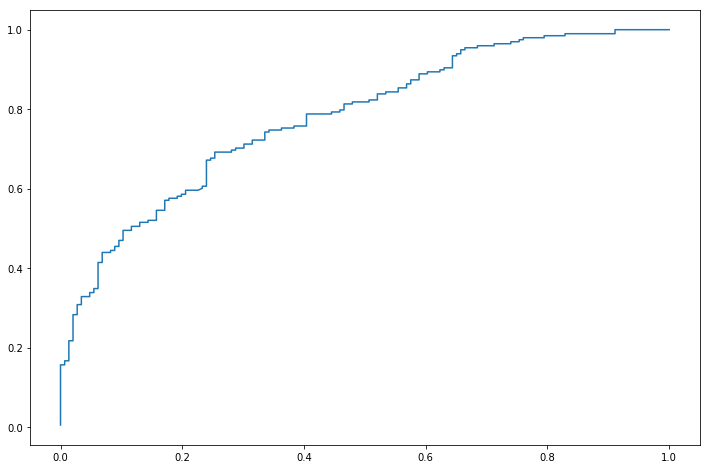

In [11]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(fpr, tpr)

In [12]:
roc_auc_score(y_test, probs[:, 1])

0.77980143904801436

In [13]:
line = np.linspace(0, 1, len(thresholds))

In [14]:
listy = []
for fp, tp, thresh, lin in zip(fpr, tpr, thresholds, line):
    listy.append({'fpr': fp, 'tpr': tp, 'thresh': thresh, 'lin': lin})

In [15]:
with open('../src/static/data/roc_data.json', 'w') as f:
    json.dump(listy, f)

In [16]:
joblib.dump(gbc_final, '../src/static/models/final_grad_boost.pkl')

['../src/static/models/final_grad_boost.pkl']

In [28]:
def threshold_prediction(model, X, threshold=0.5):
    """
    Return predictions based on threshold.
    """
    return np.where(model.predict_proba(X)[:, 1] > threshold,
                    model.classes_[1],
                    model.classes_[0])

def confusion_matrix(model, X_test, y_test, threshold=0.5):
    cf = pd.crosstab(y_test, predict(model, X_test, threshold))
    cf.index.name = 'actual'
    cf.columns.name = 'predicted'
    return cf.values

In [32]:
confusion_matrix(gbc_final, X_test, y_test, .5) * np.array([[5, -5], [-20, 10]])

predicted,0,1
actual,,
0,435,-295
1,-860,1550
